<a href="https://colab.research.google.com/github/FaisalAhmed0/variational-autoencoder/blob/main/VAEs_reimplementation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
'''
This is a reimplementation of the varitional auto encoder based on the original paper "Auto-Encoding Variational Bayes". by Kingma et.al
'''

'\nThis is a reimplementation of the varitional auto encoder based on the original paper "Auto-Encoding Variational Bayes". by Kingma et.al\n'

# Imports, Setup, and Data preperation 

In [38]:
import torch
import torch.nn as nn
import torch.optim as opt
import torch.nn.functional as F
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader

from torchvision.datasets import MNIST
from torchvision import transforms
from torchvision.utils import make_grid

import matplotlib.pyplot as plt
import numpy as np
from scipy.io import loadmat

In [3]:
# set the batch size for pytorch data loader
batch_size = 100

In [4]:
# function to load MNIST dataset
def load_mnist(batch_size):
  mnist = MNIST("./", train=True, download=True, transform=transforms.Compose([
                                                                                transforms.ToTensor()]) )
  mnist_test = MNIST("./", train=False, download=True,  transform=transforms.Compose([
                                                                              transforms.ToTensor()]) )
  mnist_dataloader = DataLoader(mnist, batch_size=batch_size)
  mnist_test_dataloader = DataLoader(mnist_test, batch_size=batch_size)
  return mnist_dataloader, mnist_test_dataloader

In [11]:
# function to load frey face dataset
def load_frey_face(batch_size):
  # download the data
  ! wget https://cs.nyu.edu/~roweis/data/frey_rawface.mat

  fileName = "frey_rawface.mat"
  frey_face_mat = loadmat(fileName) # load the mat file
  frey_face_input = torch.tensor( frey_face_mat['ff'].T.reshape(-1, 1, 28, 20))
  dummy_targets = torch.zeros(frey_face_input.shape[0])

  size = frey_face_input.shape[0]
  train_size = int(0.9 * size)
  frey_face = TensorDataset(frey_face_input[: train_size], dummy_targets[: train_size])
  frey_face_test = TensorDataset(frey_face_input[train_size: ], dummy_targets[train_size:])

  frey_face_dataloader = DataLoader(frey_face, batch_size=batch_size)
  frey_face_test_dataloader = DataLoader(frey_face_test, batch_size=batch_size)
  return frey_face_dataloader, frey_face_test_dataloader

In [27]:
# plot a batch of images as a grid.
def plot_grid(dataloader):
  images, _ = next(iter(dataloader))
  grid = make_grid(images, )
  plt.figure(figsize=(10, 10))
  plt.imshow(grid.permute(1, 2, 0))

In [35]:
# load the data
mnist, mnist_test = load_mnist(batch_size)
freyface, freyface_test = load_frey_face(batch_size)

--2021-08-18 10:17:29--  https://cs.nyu.edu/~roweis/data/frey_rawface.mat
Resolving cs.nyu.edu (cs.nyu.edu)... 216.165.22.203
Connecting to cs.nyu.edu (cs.nyu.edu)|216.165.22.203|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1100584 (1.0M) [text/plain]
Saving to: ‘frey_rawface.mat.7’

frey_rawface.mat.7  100%[===================>]   1.05M  --.-KB/s    in 0.1s    

2021-08-18 10:17:30 (8.62 MB/s) - ‘frey_rawface.mat.7’ saved [1100584/1100584]



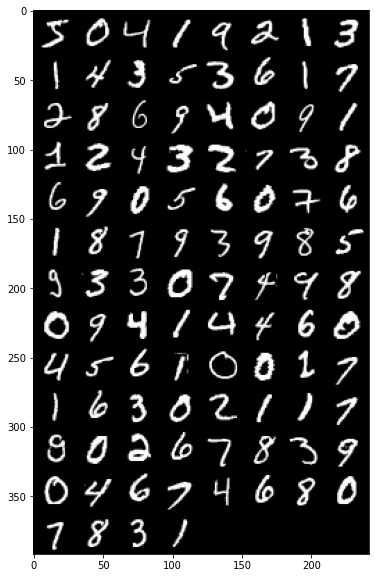

In [36]:
# plot a grid of images
plot_grid(mnist)

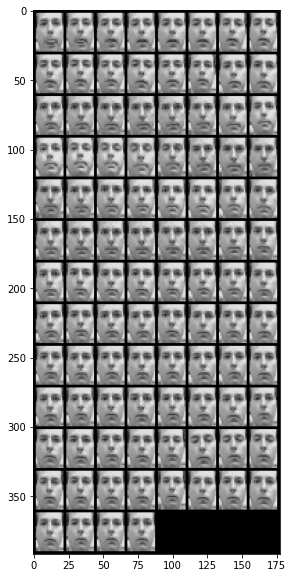

In [37]:
plot_grid(freyface)

# Model Architecture 

In [65]:
class Encoder(nn.Module):
  '''
  This class defines the encoder architecture
  '''
  def __init__(self, input_size, hidden_size, bottleneck):
    super().__init__()
    self.linear1 = nn.Linear(input_size, hidden_size)
    self.mean = nn.Linear(hidden_size, bottleneck)
    self.log_var = nn.Linear(hidden_size, bottleneck)

  def forward(self, x):
    mean = self.mean(torch.tanh(self.linear1(x)))
    log_var = self.log_var(torch.tanh(self.linear1(x)))
    return mean, log_var

In [69]:
class Decoder(nn.Module):
  '''
  This class defines the decoder architecture
  '''
  def __init__(self, bottleneck, hidden_size, input_size):
    super().__init__()
    self.linear1 = nn.Linear(bottleneck, hidden_size)
    self.mean = nn.Linear(hidden_size, input_size)
    self.log_var = nn.Linear(hidden_size, input_size)

  def forward(self, x):
    mean = self.mean(torch.tanh(self.linear1(x)))
    log_var = self.log_var(torch.tanh(self.linear1(x)))
    return mean, log_var